---------------------------------------------------------------------------------------------------

In [2]:
from qiskit import QuantumCircuit
from qiskit import transpile
from qiskit.primitives import StatevectorSampler
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit.visualization import plot_histogram, circuit_drawer

from collections import Counter
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.ticker import AutoMinorLocator, NullLocator
from qiskit.quantum_info import Statevector, DensityMatrix, partial_trace, entropy

from qiskit_experiments.library.tomography import StateTomography

In [3]:
%matplotlib inline

---------------------------------------------------------------------------------------------------

## $\textbf{Algoritmo de Bernstein Vazirani}$

---------------------------------------------------------------------------------------------------

In [ ]:

s = '110'

def orac(n, s):
    oracle = QuantumCircuit(n + 1)
    for i, bit in enumerate(reversed(s)):
        if bit == '1':
            oracle.cx(i, n)
    return oracle

def bernstein_vazirani(s):
    n = len(s)
    quantumCircuit = QuantumCircuit(n + 1, n)

    quantumCircuit.x(n)
    quantumCircuit.h(range(n + 1))
    
    quantumCircuit.barrier()

    quantumCircuit.compose(orac(n, s), inplace=True)
    
    quantumCircuit.barrier()

    quantumCircuit.h(range(n))
    quantumCircuit.measure(range(n), range(n))
    
    return quantumCircuit

fig = bernstein_vazirani(s).draw('mpl')
fig.savefig('bvorc.png', dpi=300, bbox_inches='tight')

In [8]:
bv = bernstein_vazirani(s)

---------------------------------------------------------------------------------------------------

#### $\textbf{Simulaciones}$

In [13]:
sampler = StatevectorSampler()

job = sampler.run([bv], shots=4096)

sim_result = job.result()

sim_counts_list_bv = []
estados_deseados = ['0', '1', '2', '3', '4', '5', '6', '7']  

for pub_result in sim_result:
    bits = [''.join(str(bit) for bit in b) for b in pub_result.data.c.array]
    counts = Counter(bits)

    for estado in estados_deseados:
        if estado not in counts:
            counts[estado] = 0

    sim_counts_list_bv.append(counts)

In [14]:
sim_counts_list_bv

[Counter({'6': 4096, '0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': 0, '7': 0})]

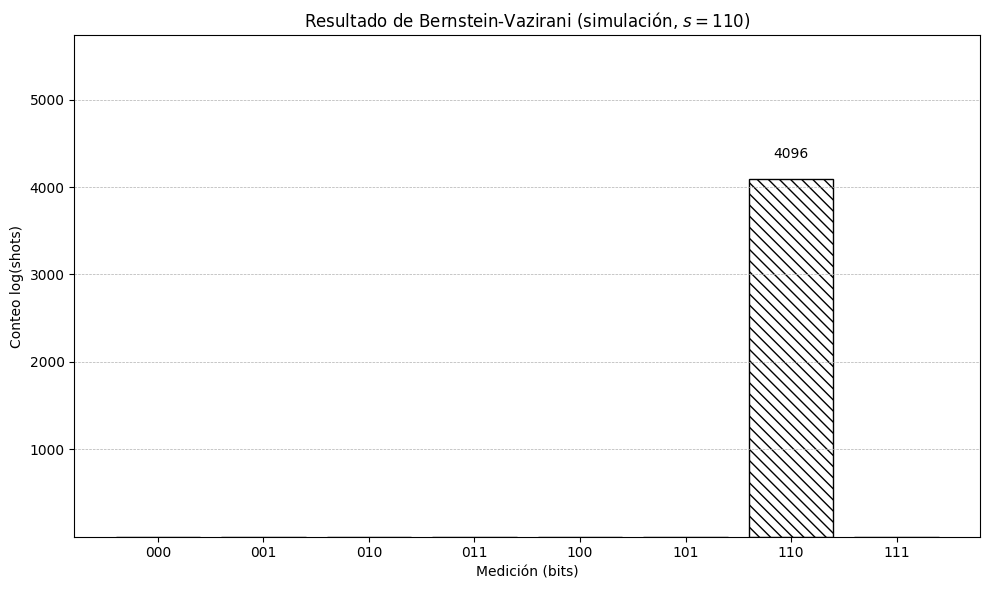

In [31]:

sim_counts = sim_counts_list_bv[0]

keys_decimal = sorted(sim_counts.keys(), key=int)
keys = [format(int(k), '03b') for k in keys_decimal]
values = [sim_counts[k] for k in keys_decimal]

hatch_map = {
    '000': '///', '001': 'xxx', '010': '---', '011': '+++',
    '100': '...', '101': '***', '110': '\\\\\\', '111': 'ooo'
}

fig, ax = plt.subplots(figsize=(10, 6))
bars = []
for i, k in enumerate(keys):
    hatch = hatch_map.get(k, '...')
    bar = ax.bar(k, values[i], color='white', edgecolor='black', hatch=hatch)
    bars.append(bar[0])  

for bar in bars:
    height = bar.get_height()
    if height > 0:
        ax.text(bar.get_x() + bar.get_width() / 2, height * 1.05, f'{int(height)}',
                ha='center', va='bottom', fontsize=10)

#ax.set_yscale('log')
ax.set_ylim(1, max(values) * 1.4)
ax.set_xlabel('Medición (bits)')
ax.set_ylabel('Conteo log(shots)')
ax.set_title('Resultado de Bernstein-Vazirani (simulación, $s=110$)')
ax.grid(True, axis='y', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.savefig('bvsim.png', dpi=300, bbox_inches='tight')
plt.show()


---------------------------------------------------------------------------------------------------

#### $\textbf{Criterio de pureza}$

In [45]:
def entrelazamiento(circuito):
    
    circuito_sinMedicion = circuito.remove_final_measurements(inplace=False)

    estadoCuantico = Statevector.from_instruction(circuito_sinMedicion)

    matriz_densidad = DensityMatrix(estadoCuantico)
    
    rho = matriz_densidad.data
    traza_matriz_densidad = np.trace(rho @ rho).real    
    
    if traza_matriz_densidad > 0.9:
        
        matriz_densidad_reducida = partial_trace(matriz_densidad, [1]).data

        pureza = (matriz_densidad_reducida @ matriz_densidad_reducida).trace().real
    
        return pureza
        
    else:
        print('No se puede afirmar nada sobre el entrelazamiento en el estado.')

In [46]:
c_0 = 's = 110 | Pureza: ' + str(entrelazamiento(bv))

print(c_0)

s = 110 | Pureza: 0.9999999999999978


---------------------------------------------------------------------------------------------------

#### $\textbf{Device IBM}$

In [17]:
def guardar_resultados(result, nombre_archivo):
    
    all_counts = []
    all_bitstrings = set()

    for i, pub_result in enumerate(result):
        bits = [''.join(str(bit) for bit in b) for b in pub_result.data.c.array]
        counts = Counter(bits)
        all_counts.append((f"circuito_{i+1}", counts))
        all_bitstrings.update(counts.keys())

    bit_columns = sorted(all_bitstrings)

    with open(nombre_archivo, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["nombre_circuito"] + bit_columns)
        for nombre, counts in all_counts:
            row = [nombre] + [counts.get(b, 0) for b in bit_columns]
            writer.writerow(row)

In [18]:
QiskitRuntimeService.save_account(token='4b8a1c91375bada9d51da5fa78db963cf7a0adb8339e5928eb279da7fdf9c8bcb179dff9a77fe25ac2ad833ba3ee84b468bdd7246efe96830667c2b425b0d153', channel='ibm_quantum', overwrite=True)

service = QiskitRuntimeService()

backend = service.least_busy(operational=True, simulator=False)

circuitos_transpilados_DJ_n2 = transpile([bv], backend=backend)

sampler = Sampler(mode=backend)

job = sampler.run(circuitos_transpilados_DJ_n2)

result = job.result()

guardar_resultados(result, 'resultado_bv.csv')

In [24]:
df = pd.read_csv("resultado_bv.csv")

estados = df.columns[1:]

real_counts_list_n3 = []
for _, fila in df.iterrows():
    counts = Counter({estado: int(fila[estado]) for estado in estados})
    real_counts_list_n3.append(counts)

nombres = df["nombre_circuito"].tolist()

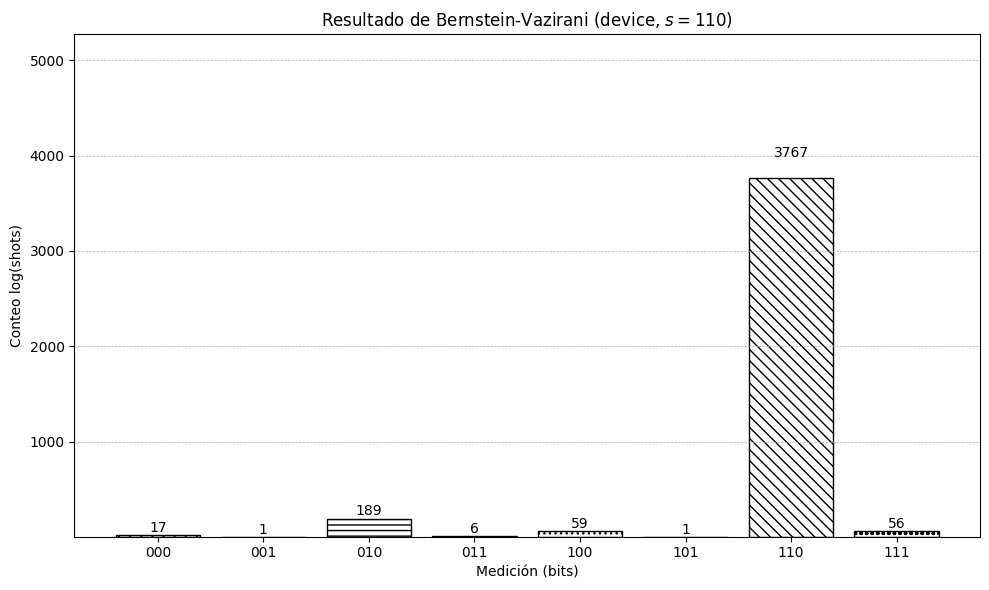

In [33]:

real_counts = real_counts_list_n3[0]

keys_decimal = sorted(real_counts.keys(), key=int)
keys = [format(int(k), '03b') for k in keys_decimal]
values = [real_counts[k] for k in keys_decimal]

hatch_map = {
    '000': '///', '001': 'xxx', '010': '---', '011': '+++',
    '100': '...', '101': '***', '110': '\\\\\\', '111': 'ooo'
}

fig, ax = plt.subplots(figsize=(10, 6))
bars = []
for i, k in enumerate(keys):
    hatch = hatch_map.get(k, '...')
    bar = ax.bar(k, values[i], color='white', edgecolor='black', hatch=hatch)
    bars.append(bar[0])  

for bar in bars:
    height = bar.get_height()
    if height > 0:
        ax.text(bar.get_x() + bar.get_width() / 2, height * 1.05, f'{int(height)}',
                ha='center', va='bottom', fontsize=10)

#ax.set_yscale('log')
ax.set_ylim(1, max(values) * 1.4)
ax.set_xlabel('Medición (bits)')
ax.set_ylabel('Conteo log(shots)')
ax.set_title('Resultado de Bernstein-Vazirani (device, $s=110$)')
ax.grid(True, axis='y', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.savefig('bvdevice.png', dpi=300, bbox_inches='tight')
plt.show()


---------------------------------------------------------------------------------------------------

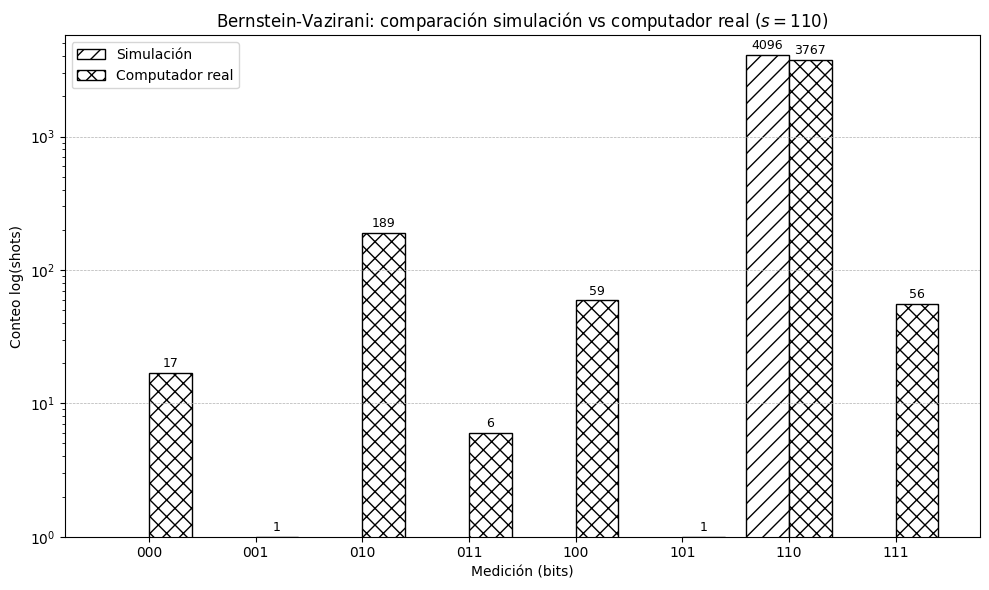

In [39]:

sim = sim_counts_list_bv[0]
real = real_counts_list_n3[0]


keys = sorted(set(sim.keys()) | set(real.keys()), key=int)
x = np.arange(len(keys))
xticks = [format(int(k), '03b') for k in keys]


sim_vals = [sim.get(k, 0) for k in keys]
real_vals = [real.get(k, 0) for k in keys]


hatch_sim = '//'
hatch_real = 'xx'


fig, ax = plt.subplots(figsize=(10, 6))


bars_sim = ax.bar(x - 0.2, sim_vals, width=0.4, label='Simulación', hatch=hatch_sim,
                  edgecolor='black', color='white')
bars_real = ax.bar(x + 0.2, real_vals, width=0.4, label='Computador real', hatch=hatch_real,
                   edgecolor='black', color='white')


for bar in bars_sim + bars_real:
    height = bar.get_height()
    if height > 0:
        ax.text(bar.get_x() + bar.get_width() / 2, height * 1.05,
                str(int(height)), ha='center', va='bottom', fontsize=9)


ax.set_yscale('log')
ax.set_ylim(1, max(sim_vals + real_vals) * 1.4)
ax.set_xticks(x)
ax.set_xticklabels(xticks)
ax.set_xlabel('Medición (bits)')
ax.set_ylabel('Conteo log(shots)')
ax.set_title('Bernstein-Vazirani: comparación simulación vs computador real ($s=110$)')
ax.grid(True, axis='y', linestyle='--', linewidth=0.5)
ax.legend()

plt.tight_layout()
plt.savefig('bv_comparacion_sim_real.png', dpi=300, bbox_inches='tight')
plt.show()
